### Python金融风控策略实战（基于Jupyter Notebook）
## <center>德国信贷风控数据建模（步骤4：特征工程之变量选择）</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.11.11</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>

### 第一步：导入需要使用的python库，并进行数据描述

In [1]:
import warnings
warnings.filterwarnings("ignore") #忽略警告
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use(arg='Qt5Agg')
matplotlib.rcParams['font.sans-serif']=['SimHei']   
matplotlib.rcParams['axes.unicode_minus']=False 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from feature_selector import FeatureSelector
%matplotlib inline

### 数据概况
数据来源：加州大学（UCI）欧文机器学习库    
http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29  

数据概况：“德国信用数据”将申请贷款的人分为“好信用”和“坏信用”，样本数据1000人，数据维度20维   

特征向量：1.支票账户状态；2.借款周期；3.历史信用；4.借款目的；5.信用额度；6.储蓄账户状态；7.当前就业状态；8.分期付款占可支配收入百分比；9.性别与婚姻状态；10.他人担保信息；11.现居住地；12.财产状态；13.年龄；14.其他分期情况；15.房产状态；16.信用卡数量；17.工作状态；18.赡养人数；19.电话号码注册情况；20.是否有海外工作经历

特征向量对应英文：1.status_account, 2.duration, 3.credit_history, 4,purpose, 5.amount, 6.svaing_account, 7.present_emp, 8.income_rate, 9.personal_status, 10.other_debtors, 11.residence_info, 12.property, 13.age, 14.inst_plans, 15.housing, 16.num_credits, 17.job, 18.dependents, 19.telephone, 20.foreign_worker    

输出结果：好信用（0），坏信用（1）   

数据收录时间：1994-11-17    

数据上传者：Professor Dr. Hans Hofmann 汉斯霍夫曼博士（德国汉堡大学）  

### 第二步：下载数据至本地，保存成csv格式，使用pandas导入数据
将数据分为data_train（训练集）和 data_test（测试集）两部分，其中训练集占总数据量80%，即800条样本数据，测试集占20%，即200条样本数据，两个数据集均通过随机抽取得到。 

In [2]:
def data_read(data_path,file_name):
    df = pd.read_csv( os.path.join(data_path, file_name), delim_whitespace = True, header = None )
    columns = ['status_account','duration','credit_history','purpose', 'amount',
               'svaing_account', 'present_emp', 'income_rate', 'personal_status',
               'other_debtors', 'residence_info', 'property', 'age',
               'inst_plans', 'housing', 'num_credits',
               'job', 'dependents', 'telephone', 'foreign_worker', 'target']
    df.columns = columns
    # 将标签变量由状态1,2转为0,1; 其中0表示好信用，1表示坏信用
    df.target = df.target - 1
    # 将数据分为data_train（训练集）和 data_test（测试集）两部分
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=0,stratify=df.target)
    # 由于训练集、测试集是随机划分，索引是乱的，需要重新排序
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    return data_train, data_test

if __name__ == '__main__':
    data_path = os.path.join('C:\\Users\\lotbear\\Desktop\\Data-science！','金融风控实战数据')
    file_name = 'german.csv'
    # 读取数据
    data_train, data_test = data_read(data_path,file_name)
    print('训练集中"好信用target=0"样本量：',sum(data_train.target ==0))
    print('训练集中"坏信用target=1"样本量：',sum(data_train.target ==1))

训练集中"好信用target=0"样本量： 560
训练集中"坏信用target=1"样本量： 240


### 第三步：区分离散/连续变量，并对变量类别进行分箱
定义函数（1）：" 离散变量 / 连续变量 " 区分函数

In [3]:
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    # 先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float',
                                                                  'int32','float32',
                                                                  'int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

实现：" 离散变量 vs 连续变量 " 分离

In [4]:
feature_names = list(data_train.columns)
feature_names.remove('target')
categorical_var,numerical_var = category_continue_separation(data_train,feature_names)
print('初始7个连续变量：','\n',numerical_var)
print('='*80)
print('初始连续变量情况：')
for s in set(numerical_var):
    print('变量'+s+'可能取值'+str(len(data_train[s].unique())))
    if len(data_train[s].unique())<=10:
        categorical_var.append(s)
        numerical_var.remove(s)
        # 同时将后加的数值变量转为字符串
        index_1 = data_train[s].isnull()
        if sum(index_1) > 0:
            data_train.loc[~index_1,s] = data_train.loc[~index_1,s].astype('str')
        else:
            data_train[s] = data_train[s].astype('str')
        index_2 = data_test[s].isnull()
        if sum(index_2) > 0:
            data_test.loc[~index_2,s] = data_test.loc[~index_2,s].astype('str')
        else:
            data_test[s] = data_test[s].astype('str')

print('='*80)
print('经转换后，剩余连续变量：','\n',numerical_var)
print('='*80)
print('离散变量：','\n',categorical_var)

初始7个连续变量： 
 ['duration', 'amount', 'income_rate', 'residence_info', 'age', 'num_credits', 'dependents']
初始连续变量情况：
变量income_rate可能取值4
变量residence_info可能取值4
变量amount可能取值744
变量dependents可能取值2
变量duration可能取值30
变量num_credits可能取值4
变量age可能取值53
经转换后，剩余连续变量： 
 ['duration', 'amount', 'age']
离散变量： 
 ['status_account', 'credit_history', 'purpose', 'svaing_account', 'present_emp', 'personal_status', 'other_debtors', 'property', 'inst_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'income_rate', 'residence_info', 'dependents', 'num_credits']


连续变量 / 离散变量分箱

In [5]:
# 连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3, mmax=12,
                                     bin_rate=0.01, stop_limit=0.05, bin_min_num=20)

# 离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3,
                                     mmax=8, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)

删除分箱数只有1个的变量

In [6]:
if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]
        
print('删除分箱数只有单个的变量：','共',len(del_key),'个')
print(del_key)

删除分箱数只有单个的变量： 共 2 个
['other_debtors', 'foreign_worker']


训练集数据分箱

In [7]:
# 连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , 
                                   varbin_meth.cont_var_bin_map(data_train[i], 
                                   dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , 
                                   varbin_meth.disc_var_bin_map(data_train[i], 
                                   dict_disc_bin[i]) ], axis = 1)

测试集数据分箱

In [8]:
# 连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , 
                                varbin_meth.cont_var_bin_map(data_test[i], 
                                dict_cont_bin[i]) ], axis = 1)

print('连续变量分箱映射：')
df_cont_bin_test

连续变量分箱映射：


,duration_BIN,amount_BIN,age_BIN
0,1,1,9
1,5,2,1
2,3,2,7
3,6,4,3
4,6,6,9
...,...,...,...
195,3,5,5
196,4,5,5
197,6,7,9
198,5,2,7


In [9]:
# 离散变量分箱映射
#    ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , 
                                  varbin_meth.disc_var_bin_map(data_test[i], 
                                  dict_disc_bin[i]) ], axis = 1)
print('离散变量分箱映射：')
df_disc_bin_test

离散变量分箱映射：


,status_account_BIN,credit_history_BIN,purpose_BIN,svaing_account_BIN,present_emp_BIN,personal_status_BIN,property_BIN,inst_plans_BIN,housing_BIN,job_BIN,telephone_BIN,income_rate_BIN,residence_info_BIN,dependents_BIN,num_credits_BIN
0,3,2,4,3,4,1,1,1,1,1,1,3,2,1,2
1,2,2,4,3,4,1,1,2,1,1,2,4,4,2,2
2,3,2,4,3,4,1,1,1,1,2,2,2,1,2,2
3,3,2,2,3,1,1,3,1,1,2,2,4,1,1,2
4,2,2,1,3,3,1,4,1,2,2,2,4,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2,2,4,3,1,1,2,1,1,2,2,2,4,2,2
196,2,2,4,2,3,1,2,1,1,2,1,2,4,2,1
197,3,2,1,3,4,2,2,1,1,3,2,2,1,2,2
198,2,1,4,1,3,2,1,1,1,2,1,2,2,2,1


组成分箱后的训练集与测试集

In [10]:
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

### 第四步：对分箱后的数据，进行WOE编码

In [11]:
# WOE编码
var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

# 训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,data_path,
                                var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')

# 测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,data_path,var_all_bin, 
                                                  data_test_bin.target, 'dict_woe_map',flag='test')
y = np.array(data_train_bin.target)
print('测试集WOE编码:')
df_test_woe[var_woe_name]

测试集WOE编码:


,duration_BIN_woe,amount_BIN_woe,age_BIN_woe,status_account_BIN_woe,credit_history_BIN_woe,purpose_BIN_woe,svaing_account_BIN_woe,present_emp_BIN_woe,personal_status_BIN_woe,property_BIN_woe,inst_plans_BIN_woe,housing_BIN_woe,job_BIN_woe,telephone_BIN_woe,income_rate_BIN_woe,residence_info_BIN_woe,dependents_BIN_woe,num_credits_BIN_woe
0,-1.267235,0.431137,0.055711,0.792238,0.089612,0.393733,0.250611,0.486683,-0.175031,-0.505095,-0.151537,-0.171998,-0.136434,-0.136336,-0.041594,-0.043675,-0.058411,0.058841
1,-0.010152,-0.254159,0.441833,0.301308,0.089612,0.393733,0.250611,0.486683,-0.175031,-0.505095,0.534206,-0.171998,-0.136434,0.090026,0.122148,0.098752,0.011380,0.058841
2,-0.311939,-0.254159,-0.762140,0.792238,0.089612,0.393733,0.250611,0.486683,-0.175031,-0.505095,-0.151537,-0.171998,-0.001890,0.090026,-0.126151,-0.057820,0.011380,0.058841
3,0.746493,0.568584,-0.060259,0.792238,0.089612,-0.656780,0.250611,-0.382154,-0.175031,0.185899,-0.151537,-0.171998,-0.001890,0.090026,0.122148,-0.057820,-0.058411,0.058841
4,0.746493,0.188052,0.055711,0.301308,0.089612,0.682995,0.250611,-0.005277,-0.175031,0.448659,-0.151537,0.292301,-0.001890,0.090026,0.122148,-0.043675,0.011380,0.058841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.311939,-0.538997,-0.123481,0.301308,0.089612,0.393733,0.250611,-0.382154,-0.175031,0.012270,-0.151537,-0.171998,-0.001890,0.090026,-0.126151,0.098752,0.011380,0.058841
196,0.459532,-0.538997,-0.123481,0.301308,0.089612,0.393733,0.135802,-0.005277,-0.175031,0.012270,-0.151537,-0.171998,-0.001890,-0.136336,-0.126151,0.098752,0.011380,-0.108214
197,0.746493,1.011601,0.055711,0.792238,0.089612,0.682995,0.250611,0.486683,0.204582,0.012270,-0.151537,-0.171998,0.154151,0.090026,-0.126151,-0.057820,0.011380,0.058841
198,-0.010152,-0.254159,-0.762140,0.301308,-0.824988,0.393733,-0.730888,-0.005277,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,-0.126151,-0.043675,0.011380,-0.108214


### 第五步：对特征变量进行选择

三种常用的变量选择方法：  

1. 过滤法（Filter）

2. 包装法（Wrapper）

3. 嵌入法（Embedding）  

============================================================================    

### <font color=blue>过滤法（Filter）特征选择</font>
a. <font color=red>方差筛选</font>：剔除方差小于阈值的变量，若方差为0，则该变量取值只有1个；  

b. <font color=red>单变量筛选</font>：通过计算变量的统计指标并排序，给出得分最高的K个变量作为最终选择；  
   其中，chi2卡方指标用于分类；f_classif方差指标用于分类；f-regresssion用于回归问题；    
   
c. <font color=red>相关性筛选</font>：留意变量间相关性较高的组合，对多个彼此相关性较高的变量进行IV值计算，保留IV值较高的一个；    
   剔除相关性较高的变量，降低变量间的共线性，去除冗余，让模型更精简有效；   
   此外，可以对变量先进行聚类，删除变量时尽量保证变量的多样性，即在不同聚类簇中删除变量。    
   
=================================================================================

<font color=red>方差筛选</font>

In [12]:
# 方差筛选
df_train_woe = df_train_woe[var_woe_name]
len_1 = df_train_woe.shape[1]
# 剔除方差小于0.01的变量，即取值少于2个的变量
select_var = VarianceThreshold(threshold=0.01)
select_var_model = select_var.fit(df_train_woe)
df_1 = pd.DataFrame(select_var_model.transform(df_train_woe))
    
# 保留的索引
save_index = select_var.get_support(True)
var_columns = [list(df_train_woe.columns)[x] for x in save_index]
df_1.columns = var_columns

# 第一轮过滤法删除的变量
del_var_1=[list(df_train_woe.columns)[x]for x in range(len_1) if x not in save_index]
print('方差小于0.01的变量名，需要剔除：','共',len(del_var_1),'个')
print(' '*80)
print(del_var_1)
print('='*80)

# 删除变量的方差
select_var.variances_[[x for x in range(len_1) if x not in save_index]]
[list(df_train_woe.columns)[x] for x in range(len_1) if x not in save_index]
[select_var.variances_[x] for x in range(len_1) if x not in save_index]

print('小方差筛选后，留存下来的变量：','共',len(var_columns),'个')
print(' '*80)
print(var_columns)

方差小于0.01的变量名，需要剔除： 共 4 个
                                                                                
['job_BIN_woe', 'residence_info_BIN_woe', 'dependents_BIN_woe', 'num_credits_BIN_woe']
小方差筛选后，留存下来的变量： 共 14 个
                                                                                
['duration_BIN_woe', 'amount_BIN_woe', 'age_BIN_woe', 'status_account_BIN_woe', 'credit_history_BIN_woe', 'purpose_BIN_woe', 'svaing_account_BIN_woe', 'present_emp_BIN_woe', 'personal_status_BIN_woe', 'property_BIN_woe', 'inst_plans_BIN_woe', 'housing_BIN_woe', 'telephone_BIN_woe', 'income_rate_BIN_woe']


<font color=red>单变量筛选</font>

In [13]:
# 选择指标 f_classif 为变量进行排序，筛选出前15个变量
select_uinvar = SelectKBest(score_func= f_classif, k=15)
# 训练模型
select_uinvar_model = select_uinvar.fit(df_train_woe,y)
var_name = [str(x).split('_BIN_woe')[0] for x in list(df_train_woe.columns)]

# 用训练的模型为原始数据挑选变量
df_1 = select_uinvar_model.transform(df_train_woe)

# DataFrame显示10列
pd.set_option('display.max_columns', 10)
print('基于f_classif指标的变量得分：')
print(' '*80)
univar_score=pd.DataFrame(data=select_uinvar_model.scores_.reshape(1,18),columns=var_name)
univar_score

基于f_classif指标的变量得分：
                                                                                


,duration,amount,age,status_account,credit_history,...,telephone,income_rate,residence_info,dependents,num_credits
0,47.175049,37.764501,27.208309,101.696155,59.736143,...,2.039699,2.567238,0.761389,0.11034,1.056954


In [14]:
univar_support=pd.DataFrame(data=select_uinvar_model.get_support().reshape(1,18),columns=var_name)
print('查看变量是否符合筛选标准：')
pd.set_option('display.max_columns', 13)
univar_support

查看变量是否符合筛选标准：


,duration,amount,age,status_account,credit_history,purpose,...,job,telephone,income_rate,residence_info,dependents,num_credits
0,True,True,True,True,True,True,...,True,True,True,False,False,False


In [15]:
pd.set_option('display.max_columns', None)

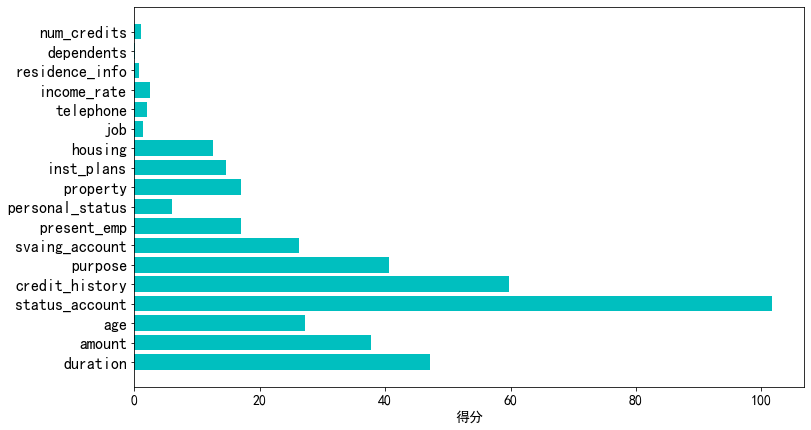

In [16]:
# 绘图，看不同变量的得分
len_1 = len(select_uinvar_model.scores_)

plt.figure(figsize=(12,7))
plt.barh(np.arange(0,len_1),select_uinvar_model.scores_,color = 'c',tick_label=var_name)
plt.xticks( fontsize=14)
plt.yticks( fontsize=16)
plt.xlabel('得分',fontsize=14)
plt.show()

<font color=red>相关性筛选</font>   
由于这18个变量之间的相关性均低于0.4，因此不需要做剔除。  

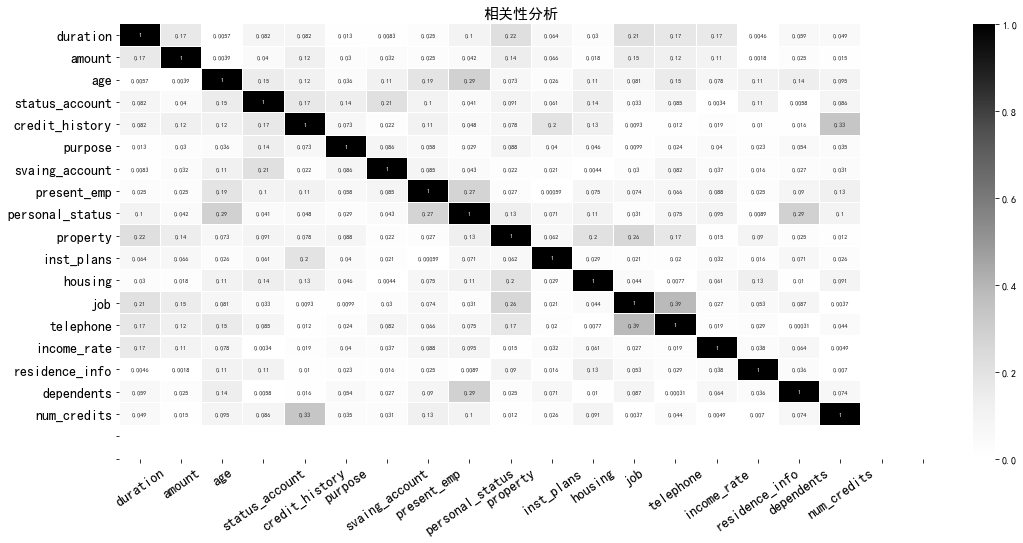

In [17]:
# 计算相关矩阵
correlations = abs(df_train_woe.corr())

# 相关性绘图
fig = plt.figure(figsize=(18,8)) 
sns.heatmap(correlations,cmap=plt.cm.Greys, linewidths=0.05,vmax=1, vmin=0 ,annot=True,annot_kws={'size':6,
                                                                                            'weight':'bold'})
plt.xticks(np.arange(20)+0.5,var_name,fontsize=14,rotation=35)
plt.yticks(np.arange(20)+0.5,var_name,fontsize=14) 
plt.title('相关性分析',fontsize=15)

#    plt.xlabel('得分',fontsize=fontsize_1)
plt.show()

### <font color=blue>包装法（Wrapper）变量选择</font>
递归消除法 

In [18]:
# 给定学习器
estimator = SVR(kernel="linear")

#递归消除法 
select_rfecv = RFECV(estimator, step=1, cv=3) # step=1 每次剔除一个变量；cv=3 进行三折交叉验证
select_rfecv_model = select_rfecv.fit(df_train_woe, y)
df_1 = pd.DataFrame(select_rfecv_model.transform(df_train_woe))
# print(df_1)

#查看结果
print('采用递归消除法筛选后，变量是否留存：')
print(select_rfecv_model.support_ )
print('='*80)
print('留存变量数：',select_rfecv_model.n_features_,'个')
# print(select_rfecv_model.ranking_)

采用递归消除法筛选后，变量是否留存：
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
留存变量数： 18 个


### <font color=blue>嵌入法（Embedding）变量选择</font>
a. 选择学习器：逻辑回归模型LogisticRegression; CART决策树模型   
b. 设定取舍变量的指标阈值   

===========================================================

<font color=red>逻辑回归模型（LR）</font>

In [19]:
# 选择学习器:逻辑回归模型
lr = LogisticRegression(C=0.1, penalty='l2')

# 嵌入法变量选择
# 阈值threshold若为整数，则指定每次剔除的变量个数；
# 阈值若为浮点数，则指定变量衡量指标的阈值大小，小于阈值则剔除变量；
# 阈值为字符串，如本例中的‘mean’则将指标的均值作为阈值。
select_lr = SelectFromModel(lr, prefit=False,threshold ='mean') 
select_lr_model = select_lr.fit(df_train_woe, y)
df_1 = pd.DataFrame(select_lr_model.transform(df_train_woe))

#查看结果
print("变量选取的指标阈值：",select_lr_model.threshold_)
print('='*80)
lr_support=pd.DataFrame(data=select_lr_model.get_support(False).reshape(1,18),columns=var_name)
print('查看变量是否符合筛选标准：')
lr_support

变量选取的指标阈值： 0.3699396900060411
查看变量是否符合筛选标准：


,duration,amount,age,status_account,credit_history,purpose,svaing_account,present_emp,personal_status,property,inst_plans,housing,job,telephone,income_rate,residence_info,dependents,num_credits
0,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False


<font color=red>CART决策树</font>

In [20]:
# 先训练决策树
cart_model = DecisionTreeClassifier(criterion='gini',max_depth = 3).fit(df_train_woe, y)
print('基于Gini系数的变量重要性值：')
print(' '*80)
gini_var=pd.DataFrame(data=cart_model.feature_importances_.reshape(1,18),columns=var_name)
print(gini_var)
print('='*80)

# 用预训练模型进行变量选择
select_dt_model = SelectFromModel(cart_model, prefit=True)
df_1 = pd.DataFrame(select_dt_model.transform(df_train_woe))

#查看结果
dt_support=pd.DataFrame(data=select_dt_model.get_support(False).reshape(1,18),columns=var_name)
print('查看变量是否符合筛选标准：')
dt_support

基于Gini系数的变量重要性值：
                                                                                
   duration    amount  age  status_account  credit_history   purpose  \
0  0.153068  0.146451  0.0        0.488293             0.0  0.072773   

   svaing_account  present_emp  personal_status  property  inst_plans  \
0        0.073452          0.0              0.0       0.0    0.065964   

   housing  job  telephone  income_rate  residence_info  dependents  \
0      0.0  0.0        0.0          0.0             0.0         0.0   

   num_credits  
0          0.0  
查看变量是否符合筛选标准：


,duration,amount,age,status_account,credit_history,purpose,svaing_account,present_emp,personal_status,property,inst_plans,housing,job,telephone,income_rate,residence_info,dependents,num_credits
0,True,True,False,True,False,True,True,False,False,False,True,False,False,False,False,False,False,False


### <font color=blue>集成学习下的变量选择——lightgbm模型</font>
<font color=red>lightgbm模型</font>   

该模型整合了常见的变量选择方法，如缺失值筛选、共线相关性筛选、方差筛选（方差为0）、变量重要性排序等，是梯度提升算法的一种改进。

In [21]:
fs = FeatureSelector(data = df_train_woe, labels = y)

#设置筛选参数
fs.identify_all(selection_params = {'missing_threshold': 0.9, # 缺失值阈值指标
                                    'correlation_threshold': 0.6, # 共线相关性阈值指标
                                    'task': 'classification', # 任务：分类
                                    'eval_metric': 'binary_error',# 
                                    'max_depth':2,# 最大深度
                                    'cumulative_importance': 0.90})# 累计重要性指标
df_train_woe = fs.remove(methods = 'all')

0 features with greater than 0.90 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.60.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.25	valid_0's binary_logloss: 0.523701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.233333	valid_0's binary_logloss: 0.504335
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.225	valid_0's binary_logloss: 0.546442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.283333	valid_0's binary_logloss: 0.495728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.308333	valid_0'

In [22]:
print('变量重要性分值排序（从高到低）：')
fs.feature_importances

变量重要性分值排序（从高到低）：


,feature,importance,normalized_importance,cumulative_importance
0,duration_BIN_woe,107.5,0.128727,0.128727
1,age_BIN_woe,100.5,0.120345,0.249072
2,purpose_BIN_woe,80.8,0.096755,0.345827
3,status_account_BIN_woe,67.5,0.080829,0.426655
4,income_rate_BIN_woe,63.9,0.076518,0.503173
5,credit_history_BIN_woe,54.4,0.065142,0.568315
6,amount_BIN_woe,54.1,0.064783,0.633098
7,present_emp_BIN_woe,52.4,0.062747,0.695845
8,property_BIN_woe,48.7,0.058316,0.754161
9,svaing_account_BIN_woe,38.9,0.046581,0.800742


In [23]:
print('变量相关性矩阵：')
fs.corr_matrix

变量相关性矩阵：


,duration_BIN_woe,amount_BIN_woe,age_BIN_woe,status_account_BIN_woe,credit_history_BIN_woe,purpose_BIN_woe,svaing_account_BIN_woe,present_emp_BIN_woe,personal_status_BIN_woe,property_BIN_woe,inst_plans_BIN_woe,housing_BIN_woe,job_BIN_woe,telephone_BIN_woe,income_rate_BIN_woe,residence_info_BIN_woe,dependents_BIN_woe,num_credits_BIN_woe
duration_BIN_woe,1.000000,0.166889,0.005737,0.082077,0.082441,0.013384,0.008269,-0.024523,-0.100812,0.215851,0.064021,0.029618,0.208415,-0.173870,0.166317,-0.004634,0.059390,-0.048592
amount_BIN_woe,0.166889,1.000000,-0.003944,0.039810,0.122739,0.030207,-0.031539,0.024957,-0.041632,0.141176,0.066076,-0.018158,0.151235,-0.122105,-0.105060,0.001823,0.025340,-0.014616
age_BIN_woe,0.005737,-0.003944,1.000000,0.147149,0.117368,-0.036025,0.113434,0.190020,0.288426,-0.073289,-0.025804,0.107476,-0.080903,0.154331,-0.077597,0.106960,0.135496,0.094668
status_account_BIN_woe,0.082077,0.039810,0.147149,1.000000,0.167985,0.138984,0.212921,0.104299,0.040661,0.091484,0.061119,0.136956,-0.033107,0.084834,-0.003353,-0.108084,-0.005846,0.086214
credit_history_BIN_woe,0.082441,0.122739,0.117368,0.167985,1.000000,0.073200,0.022148,0.110605,0.047968,0.078355,0.198427,0.128061,-0.009275,0.011727,-0.019398,-0.010357,-0.015528,0.333330
purpose_BIN_woe,0.013384,0.030207,-0.036025,0.138984,0.073200,1.000000,0.085904,0.058366,0.028857,0.087832,0.039752,0.046389,-0.009871,-0.023714,-0.039841,-0.023198,-0.053621,-0.035490
svaing_account_BIN_woe,0.008269,-0.031539,0.113434,0.212921,0.022148,0.085904,1.000000,0.084558,0.043468,-0.022221,-0.021403,0.004416,-0.029846,0.082208,-0.037123,0.015717,0.026868,-0.031440
present_emp_BIN_woe,-0.024523,0.024957,0.190020,0.104299,0.110605,0.058366,0.084558,1.000000,0.272165,-0.026766,0.000587,0.075099,0.073726,0.066061,-0.088094,0.025208,0.089702,0.125855
personal_status_BIN_woe,-0.100812,-0.041632,0.288426,0.040661,0.047968,0.028857,0.043468,0.272165,1.000000,-0.130079,-0.070570,0.112327,-0.030564,0.075242,-0.095481,-0.008874,0.287550,0.101926
property_BIN_woe,0.215851,0.141176,-0.073289,0.091484,0.078355,0.087832,-0.022221,-0.026766,-0.130079,1.000000,0.062498,0.203788,0.259761,-0.173340,0.015025,-0.089915,-0.025244,0.011741


In [24]:
print('通过 lightgbm 集成学习，删除6个重要性较低的变量：')
fs.record_low_importance

通过 lightgbm 集成学习，删除6个重要性较低的变量：


,feature,importance,normalized_importance,cumulative_importance
12,inst_plans_BIN_woe,27.2,0.032571,0.909951
13,telephone_BIN_woe,25.1,0.030056,0.940007
14,num_credits_BIN_woe,20.3,0.024308,0.964316
15,housing_BIN_woe,15.2,0.018201,0.982517
16,job_BIN_woe,10.2,0.012214,0.994731
17,dependents_BIN_woe,4.4,0.005269,1.000000
